## setup


In [1]:
# Install necessary libraries
!pip install torchinfo torchmetrics

# Import required libraries
import os
import zipfile
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchinfo import summary
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm

# Set device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

## custom dataset

In [2]:
class PairedImageZipDataset(Dataset):
    """
    Custom PyTorch Dataset for loading paired images from a zip file.
    Assumes the zip file contains two folders: 'input' and 'target'
    with identically named files.

    Args:
        zip_path (str): Path to the zip file.
        transform (callable, optional): A function/transform to apply to the images.
    """
    def __init__(self, zip_path="archive.zip", transform=None):
        self.zip_path = zip_path
        self.transform = transform

        # Open the zip file and get the list of image paths
        with zipfile.ZipFile(self.zip_path, 'r') as z:
            # Assuming the structure is archive.zip/Rain100L/input/ and archive.zip/Rain100L/target/
            # We list files in the input directory and assume corresponding files exist in target
            input_files = [f for f in z.namelist() if f.startswith('Rain100L/input/') and (f.endswith('.png') or f.endswith('.jpg'))]

            self.input_paths = sorted(input_files)
            # Create corresponding target paths
            self.target_paths = [p.replace('input', 'target') for p in self.input_paths]

        # We need to keep the zipfile object open to read from it
        # self.zip_file = zipfile.ZipFile(self.zip_path, 'r') # This was causing issues with multiprocessing

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        # Open the zip file and read the images within this method
        with zipfile.ZipFile(self.zip_path, 'r') as z:
            # Open and read the input image from the zip file
            with z.open(self.input_paths[idx]) as f:
                input_image = Image.open(f).convert("RGB")

            # Open and read the target image from the zip file
            with z.open(self.target_paths[idx]) as f:
                target_image = Image.open(f).convert("RGB")

        # Apply transformations if any
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Define image transformations
# Images will be resized and normalized to the range [-1, 1]
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create the dataset
# Make sure 'archive.zip' is in your Colab root directory
try:
    full_dataset = PairedImageZipDataset(zip_path="archive.zip", transform=image_transform)

    # Split dataset into training and testing sets (e.g., 90% train, 10% test)
    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # Create DataLoaders
    BATCH_SIZE = 4
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Set num_workers to 0
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)  # Set num_workers to 0

    print(f"Dataset loaded successfully.")
    print(f"Total images: {len(full_dataset)}")
    print(f"Training images: {len(train_dataset)}")
    print(f"Testing images: {len(test_dataset)}")

except FileNotFoundError:
    print("Error: 'archive.zip' not found. Please upload your dataset.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure your zip file has the structure: 'Rain100L/input/' and 'Rain100L/target/'.")

Dataset loaded successfully.
Total images: 100
Training images: 90
Testing images: 10


## model

In [3]:
# --- Generator (U-Net) ---

class UNetDown(nn.Module):
    """A downsampling block in the U-Net."""
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    """An upsampling block in the U-Net with skip connections."""
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class Generator(nn.Module):
    """The U-Net Generator."""
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Downsampling path
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        # Upsampling path with skip connections
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        # Final layer to produce the output image
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh() # Tanh activation to scale output to [-1, 1]
        )

    def forward(self, x):
        # Propagate through the U-Net
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final_up(u7)

# --- Discriminator (PatchGAN) ---

class Discriminator(nn.Module):
    """The PatchGAN Discriminator."""
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block."""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # The input to the discriminator is the concatenation of the input image and the target/generated image
        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)


# train

In [4]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# --- Weight Initialization ---
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# --- Print Model Summaries ---
# The input size for the summary should match our data (Batch, Channels, Height, Width)
input_size = (BATCH_SIZE, 3, 256, 256)

print("--- Generator Summary ---")
summary(generator, input_size=input_size)

print("\n--- Discriminator Summary ---")
# Discriminator takes two images, but we define the input shape based on the concatenated input
summary(discriminator, input_size=[input_size, input_size])


--- Generator Summary ---

--- Discriminator Summary ---


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [4, 1, 16, 16]            --
├─Sequential: 1-1                        [4, 1, 16, 16]            --
│    └─Conv2d: 2-1                       [4, 64, 128, 128]         6,208
│    └─LeakyReLU: 2-2                    [4, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [4, 128, 64, 64]          131,200
│    └─InstanceNorm2d: 2-4               [4, 128, 64, 64]          --
│    └─LeakyReLU: 2-5                    [4, 128, 64, 64]          --
│    └─Conv2d: 2-6                       [4, 256, 32, 32]          524,544
│    └─InstanceNorm2d: 2-7               [4, 256, 32, 32]          --
│    └─LeakyReLU: 2-8                    [4, 256, 32, 32]          --
│    └─Conv2d: 2-9                       [4, 512, 16, 16]          2,097,664
│    └─InstanceNorm2d: 2-10              [4, 512, 16, 16]          --
│    └─LeakyReLU: 2-11                   [4, 512, 16, 16]        

In [6]:
# --- Hyperparameters ---
EPOCHS = 200
LR = 0.0002
B1 = 0.5
B2 = 0.999
LAMBDA_L1 = 100 # Weight for L1 loss

# --- Loss Functions ---
adversarial_loss = nn.BCEWithLogitsLoss() # More stable than BCELoss
l1_loss = nn.L1Loss()

# --- Optimizers ---
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

# --- Training History ---
train_losses_G = []
train_losses_D = []
eval_losses_G = []
eval_losses_D = []

# --- Training ---
print("Starting Training...")

for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()

    running_loss_G = 0.0
    running_loss_D = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for i, (real_A, real_B) in progress_bar:
        # real_A is the rainy image (input)
        # real_B is the clean image (ground truth)
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # Adversarial ground truths for training
        # We use soft labels (e.g., 0.9 instead of 1.0) for stability
        valid = torch.full((real_A.size(0), 1, 16, 16), 0.9, dtype=torch.float32, device=device)
        fake = torch.full((real_A.size(0), 1, 16, 16), 0.1, dtype=torch.float32, device=device)

        # ------------------
        #  Train Generator
        # ------------------
        optimizer_G.zero_grad()

        # Generate a fake image
        fake_B = generator(real_A)

        # Loss measures generator's ability to fool the discriminator
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = adversarial_loss(pred_fake, valid)

        # Pixel-wise L1 loss
        loss_pixel = l1_loss(fake_B, real_B)

        # Total generator loss
        loss_G = loss_GAN + LAMBDA_L1 * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = adversarial_loss(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = adversarial_loss(pred_fake, fake)

        # Total discriminator loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()

        progress_bar.set_postfix(
            Loss_D=loss_D.item(),
            Loss_G=loss_G.item(),
            GAN=loss_GAN.item(),
            L1=loss_pixel.item()
        )

    # --- End of Epoch: Record and Evaluate ---
    avg_train_loss_G = running_loss_G / len(train_loader)
    avg_train_loss_D = running_loss_D / len(train_loader)
    train_losses_G.append(avg_train_loss_G)
    train_losses_D.append(avg_train_loss_D)

    # Evaluation phase
    generator.eval()
    discriminator.eval()
    eval_loss_G = 0.0
    eval_loss_D = 0.0
    with torch.no_grad():
        for real_A, real_B in test_loader:
            real_A, real_B = real_A.to(device), real_B.to(device)

            # Adversarial ground truths for evaluation (adjust based on current batch size)
            valid_eval = torch.full((real_A.size(0), 1, 16, 16), 0.9, dtype=torch.float32, device=device)
            fake_eval = torch.full((real_A.size(0), 1, 16, 16), 0.1, dtype=torch.float32, device=device)

            fake_B = generator(real_A)

            # Eval Generator Loss
            pred_fake_eval = discriminator(fake_B, real_A)
            loss_GAN_eval = adversarial_loss(pred_fake_eval, valid_eval) # Use valid_eval
            loss_pixel_eval = l1_loss(fake_B, real_B)
            eval_loss_G += (loss_GAN_eval + LAMBDA_L1 * loss_pixel_eval).item()

            # Eval Discriminator Loss
            pred_real_eval = discriminator(real_B, real_A)
            loss_real_eval = adversarial_loss(pred_real_eval, valid_eval) # Use valid_eval
            pred_fake_eval_d = discriminator(fake_B.detach(), real_A)
            loss_fake_eval = adversarial_loss(pred_fake_eval_d, fake_eval) # Use fake_eval
            eval_loss_D += (0.5 * (loss_real_eval + loss_fake_eval)).item()

    avg_eval_loss_G = eval_loss_G / len(test_loader)
    avg_eval_loss_D = eval_loss_D / len(test_loader)
    eval_losses_G.append(avg_eval_loss_G)
    eval_losses_D.append(avg_eval_loss_D)

    print(f"\nEnd of Epoch {epoch+1}/{EPOCHS} -> Train Loss G: {avg_train_loss_G:.4f}, D: {avg_train_loss_D:.4f} | Eval Loss G: {avg_eval_loss_G:.4f}, D: {avg_eval_loss_D:.4f}")

print("Finished Training.")

Starting Training...


Epoch 1/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 1/200 -> Train Loss G: 20.3008, D: 0.7294 | Eval Loss G: 19.0818, D: 0.7476


Epoch 2/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 2/200 -> Train Loss G: 17.3812, D: 0.6785 | Eval Loss G: 16.0289, D: 0.6552


Epoch 3/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 3/200 -> Train Loss G: 14.8276, D: 0.6621 | Eval Loss G: 14.4482, D: 0.7034


Epoch 4/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 4/200 -> Train Loss G: 13.2934, D: 0.6132 | Eval Loss G: 13.2430, D: 0.6062


Epoch 5/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 5/200 -> Train Loss G: 12.5196, D: 0.5490 | Eval Loss G: 13.0563, D: 0.6405


Epoch 6/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 6/200 -> Train Loss G: 11.8388, D: 0.5605 | Eval Loss G: 11.5232, D: 0.5387


Epoch 7/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 7/200 -> Train Loss G: 11.1707, D: 0.5497 | Eval Loss G: 11.5843, D: 0.5667


Epoch 8/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 8/200 -> Train Loss G: 10.9707, D: 0.5554 | Eval Loss G: 10.9665, D: 0.6292


Epoch 9/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 9/200 -> Train Loss G: 10.5188, D: 0.5525 | Eval Loss G: 12.1352, D: 1.0782


Epoch 10/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 10/200 -> Train Loss G: 10.3549, D: 0.5639 | Eval Loss G: 9.7840, D: 0.5023


Epoch 11/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 11/200 -> Train Loss G: 10.1250, D: 0.5448 | Eval Loss G: 9.6315, D: 0.5434


Epoch 12/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 12/200 -> Train Loss G: 9.7998, D: 0.5760 | Eval Loss G: 9.3211, D: 0.5348


Epoch 13/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 13/200 -> Train Loss G: 9.4857, D: 0.5280 | Eval Loss G: 8.7951, D: 0.7429


Epoch 14/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 14/200 -> Train Loss G: 9.3812, D: 0.5888 | Eval Loss G: 9.0105, D: 0.5667


Epoch 15/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 15/200 -> Train Loss G: 9.1930, D: 0.5731 | Eval Loss G: 8.6734, D: 0.6139


Epoch 16/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 16/200 -> Train Loss G: 9.0152, D: 0.5872 | Eval Loss G: 9.2949, D: 0.6400


Epoch 17/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 17/200 -> Train Loss G: 8.7807, D: 0.5543 | Eval Loss G: 9.5646, D: 0.8371


Epoch 18/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 18/200 -> Train Loss G: 8.5602, D: 0.6177 | Eval Loss G: 8.4733, D: 0.6001


Epoch 19/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 19/200 -> Train Loss G: 8.3770, D: 0.5593 | Eval Loss G: 9.1462, D: 0.7211


Epoch 20/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 20/200 -> Train Loss G: 8.2061, D: 0.5885 | Eval Loss G: 8.5539, D: 0.5534


Epoch 21/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 21/200 -> Train Loss G: 8.2742, D: 0.5666 | Eval Loss G: 8.8965, D: 0.6730


Epoch 22/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 22/200 -> Train Loss G: 8.1510, D: 0.6000 | Eval Loss G: 7.5913, D: 0.6761


Epoch 23/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 23/200 -> Train Loss G: 7.8155, D: 0.5606 | Eval Loss G: 8.5265, D: 0.5094


Epoch 24/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 24/200 -> Train Loss G: 7.8603, D: 0.5901 | Eval Loss G: 8.1221, D: 0.5627


Epoch 25/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 25/200 -> Train Loss G: 7.5534, D: 0.5839 | Eval Loss G: 7.7365, D: 0.5237


Epoch 26/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 26/200 -> Train Loss G: 7.5933, D: 0.6367 | Eval Loss G: 7.4250, D: 0.7100


Epoch 27/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 27/200 -> Train Loss G: 7.3006, D: 0.5620 | Eval Loss G: 8.0150, D: 0.7761


Epoch 28/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 28/200 -> Train Loss G: 7.2782, D: 0.5737 | Eval Loss G: 7.8863, D: 0.5805


Epoch 29/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 29/200 -> Train Loss G: 7.5528, D: 0.5862 | Eval Loss G: 8.1249, D: 0.7014


Epoch 30/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 30/200 -> Train Loss G: 7.1917, D: 0.5480 | Eval Loss G: 8.1727, D: 0.6201


Epoch 31/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 31/200 -> Train Loss G: 7.2340, D: 0.5904 | Eval Loss G: 7.4777, D: 0.5379


Epoch 32/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 32/200 -> Train Loss G: 6.9920, D: 0.5788 | Eval Loss G: 7.9223, D: 0.6037


Epoch 33/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 33/200 -> Train Loss G: 7.0539, D: 0.5689 | Eval Loss G: 7.5565, D: 0.5322


Epoch 34/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 34/200 -> Train Loss G: 7.0026, D: 0.5801 | Eval Loss G: 7.8996, D: 0.7625


Epoch 35/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 35/200 -> Train Loss G: 6.6642, D: 0.8112 | Eval Loss G: 7.2663, D: 0.6323


Epoch 36/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 36/200 -> Train Loss G: 6.4961, D: 0.5439 | Eval Loss G: 7.0925, D: 0.5259


Epoch 37/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 37/200 -> Train Loss G: 6.6296, D: 0.6073 | Eval Loss G: 6.4319, D: 0.7713


Epoch 38/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 38/200 -> Train Loss G: 6.3122, D: 0.6127 | Eval Loss G: 7.1544, D: 0.5864


Epoch 39/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 39/200 -> Train Loss G: 6.4988, D: 0.5399 | Eval Loss G: 7.2198, D: 0.5244


Epoch 40/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 40/200 -> Train Loss G: 6.5041, D: 0.6139 | Eval Loss G: 7.2084, D: 0.6112


Epoch 41/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 41/200 -> Train Loss G: 6.2996, D: 0.5720 | Eval Loss G: 8.2308, D: 0.9637


Epoch 42/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 42/200 -> Train Loss G: 6.3460, D: 0.5881 | Eval Loss G: 7.6183, D: 0.6470


Epoch 43/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 43/200 -> Train Loss G: 6.3083, D: 0.5573 | Eval Loss G: 7.8369, D: 0.5584


Epoch 44/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 44/200 -> Train Loss G: 6.4462, D: 0.6314 | Eval Loss G: 6.7368, D: 0.8187


Epoch 45/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 45/200 -> Train Loss G: 5.9698, D: 0.6302 | Eval Loss G: 6.9879, D: 0.5600


Epoch 46/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 46/200 -> Train Loss G: 6.1265, D: 0.5680 | Eval Loss G: 7.2265, D: 0.6062


Epoch 47/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 47/200 -> Train Loss G: 6.4380, D: 0.5494 | Eval Loss G: 6.8203, D: 0.8516


Epoch 48/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 48/200 -> Train Loss G: 5.8356, D: 0.7373 | Eval Loss G: 6.8333, D: 0.5850


Epoch 49/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 49/200 -> Train Loss G: 5.9948, D: 0.5354 | Eval Loss G: 7.6757, D: 0.6173


Epoch 50/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 50/200 -> Train Loss G: 6.3262, D: 0.5187 | Eval Loss G: 6.6608, D: 0.4731


Epoch 51/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 51/200 -> Train Loss G: 6.6205, D: 0.4293 | Eval Loss G: 7.6111, D: 0.7773


Epoch 52/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 52/200 -> Train Loss G: 6.5656, D: 0.4841 | Eval Loss G: 8.8132, D: 0.4862


Epoch 53/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 53/200 -> Train Loss G: 6.7038, D: 0.4551 | Eval Loss G: 8.4450, D: 0.3609


Epoch 54/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 54/200 -> Train Loss G: 6.9561, D: 0.3738 | Eval Loss G: 9.1968, D: 0.5327


Epoch 55/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 55/200 -> Train Loss G: 6.4285, D: 0.5569 | Eval Loss G: 7.6883, D: 0.4472


Epoch 56/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 56/200 -> Train Loss G: 6.4839, D: 0.4196 | Eval Loss G: 7.9936, D: 0.4224


Epoch 57/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 57/200 -> Train Loss G: 6.3695, D: 0.5378 | Eval Loss G: 6.7620, D: 0.4402


Epoch 58/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 58/200 -> Train Loss G: 6.5349, D: 0.4427 | Eval Loss G: 7.6054, D: 0.5283


Epoch 59/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 59/200 -> Train Loss G: 6.2874, D: 0.4452 | Eval Loss G: 8.6935, D: 0.4000


Epoch 60/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 60/200 -> Train Loss G: 6.7610, D: 0.3943 | Eval Loss G: 8.2192, D: 0.3554


Epoch 61/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 61/200 -> Train Loss G: 6.6709, D: 0.3820 | Eval Loss G: 8.5094, D: 0.4040


Epoch 62/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 62/200 -> Train Loss G: 6.5307, D: 0.4777 | Eval Loss G: 7.5981, D: 0.5002


Epoch 63/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 63/200 -> Train Loss G: 5.7878, D: 0.6894 | Eval Loss G: 7.0050, D: 0.4437


Epoch 64/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 64/200 -> Train Loss G: 5.8794, D: 0.4817 | Eval Loss G: 7.7526, D: 0.4610


Epoch 65/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 65/200 -> Train Loss G: 6.2473, D: 0.4242 | Eval Loss G: 7.8931, D: 0.3501


Epoch 66/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 66/200 -> Train Loss G: 6.2103, D: 0.4901 | Eval Loss G: 7.7708, D: 0.3534


Epoch 67/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 67/200 -> Train Loss G: 6.2581, D: 0.4508 | Eval Loss G: 7.8022, D: 0.6787


Epoch 68/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 68/200 -> Train Loss G: 5.3874, D: 0.7691 | Eval Loss G: 6.2342, D: 0.7360


Epoch 69/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 69/200 -> Train Loss G: 5.0379, D: 0.6661 | Eval Loss G: 6.2506, D: 0.6701


Epoch 70/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 70/200 -> Train Loss G: 5.0348, D: 0.6302 | Eval Loss G: 6.6110, D: 0.7343


Epoch 71/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 71/200 -> Train Loss G: 5.1164, D: 0.5823 | Eval Loss G: 7.4462, D: 0.5462


Epoch 72/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 72/200 -> Train Loss G: 5.5897, D: 0.4834 | Eval Loss G: 7.9637, D: 0.3893


Epoch 73/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 73/200 -> Train Loss G: 6.2545, D: 0.4216 | Eval Loss G: 7.1721, D: 0.4065


Epoch 74/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 74/200 -> Train Loss G: 5.5682, D: 0.6766 | Eval Loss G: 6.1734, D: 0.7420


Epoch 75/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 75/200 -> Train Loss G: 4.9571, D: 0.6389 | Eval Loss G: 6.7583, D: 0.5283


Epoch 76/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 76/200 -> Train Loss G: 5.5150, D: 0.4550 | Eval Loss G: 7.5213, D: 0.3522


Epoch 77/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 77/200 -> Train Loss G: 5.5032, D: 0.5655 | Eval Loss G: 7.2650, D: 0.4951


Epoch 78/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 78/200 -> Train Loss G: 5.4866, D: 0.5735 | Eval Loss G: 7.0104, D: 0.4303


Epoch 79/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 79/200 -> Train Loss G: 5.6010, D: 0.4738 | Eval Loss G: 7.9097, D: 0.3510


Epoch 80/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 80/200 -> Train Loss G: 5.6996, D: 0.4948 | Eval Loss G: 8.0338, D: 0.4154


Epoch 81/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 81/200 -> Train Loss G: 5.7320, D: 0.4221 | Eval Loss G: 8.3770, D: 0.4828


Epoch 82/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 82/200 -> Train Loss G: 5.4776, D: 0.5655 | Eval Loss G: 7.3653, D: 0.3670


Epoch 83/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 83/200 -> Train Loss G: 5.7594, D: 0.4323 | Eval Loss G: 8.0035, D: 0.6044


Epoch 84/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 84/200 -> Train Loss G: 5.6793, D: 0.4730 | Eval Loss G: 7.2227, D: 0.3878


Epoch 85/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 85/200 -> Train Loss G: 5.6494, D: 0.5458 | Eval Loss G: 7.4741, D: 0.5760


Epoch 86/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 86/200 -> Train Loss G: 5.4939, D: 0.4897 | Eval Loss G: 7.1365, D: 0.3687


Epoch 87/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 87/200 -> Train Loss G: 5.7920, D: 0.4415 | Eval Loss G: 6.6928, D: 0.4541


Epoch 88/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 88/200 -> Train Loss G: 5.6268, D: 0.4975 | Eval Loss G: 7.9456, D: 0.9118


Epoch 89/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 89/200 -> Train Loss G: 5.4292, D: 0.5691 | Eval Loss G: 6.0627, D: 0.8211


Epoch 90/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 90/200 -> Train Loss G: 5.2384, D: 0.5343 | Eval Loss G: 7.6314, D: 0.3989


Epoch 91/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 91/200 -> Train Loss G: 5.5792, D: 0.4223 | Eval Loss G: 7.9250, D: 0.3853


Epoch 92/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 92/200 -> Train Loss G: 6.0065, D: 0.3898 | Eval Loss G: 8.5531, D: 0.4641


Epoch 93/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 93/200 -> Train Loss G: 5.5003, D: 0.5720 | Eval Loss G: 7.0664, D: 0.4122


Epoch 94/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 94/200 -> Train Loss G: 5.3182, D: 0.4946 | Eval Loss G: 7.1993, D: 0.3613


Epoch 95/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 95/200 -> Train Loss G: 5.5265, D: 0.4318 | Eval Loss G: 8.3208, D: 0.3710


Epoch 96/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 96/200 -> Train Loss G: 5.7842, D: 0.3953 | Eval Loss G: 7.4254, D: 0.3545


Epoch 97/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 97/200 -> Train Loss G: 5.7491, D: 0.4133 | Eval Loss G: 8.6798, D: 0.5655


Epoch 98/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 98/200 -> Train Loss G: 5.5557, D: 0.5316 | Eval Loss G: 7.5301, D: 1.1057


Epoch 99/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 99/200 -> Train Loss G: 5.1180, D: 0.8856 | Eval Loss G: 6.6402, D: 0.4573


Epoch 100/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 100/200 -> Train Loss G: 5.0245, D: 0.4904 | Eval Loss G: 7.6614, D: 0.3912


Epoch 101/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 101/200 -> Train Loss G: 5.2062, D: 0.5391 | Eval Loss G: 6.9089, D: 0.7251


Epoch 102/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 102/200 -> Train Loss G: 5.0829, D: 0.4991 | Eval Loss G: 7.2431, D: 0.3712


Epoch 103/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 103/200 -> Train Loss G: 5.4232, D: 0.4064 | Eval Loss G: 8.3387, D: 0.4853


Epoch 104/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 104/200 -> Train Loss G: 5.4372, D: 0.5066 | Eval Loss G: 6.8939, D: 0.5201


Epoch 105/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 105/200 -> Train Loss G: 5.0402, D: 0.5749 | Eval Loss G: 6.8462, D: 0.4722


Epoch 106/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 106/200 -> Train Loss G: 5.1619, D: 0.4421 | Eval Loss G: 7.9704, D: 0.4636


Epoch 107/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 107/200 -> Train Loss G: 5.4938, D: 0.4208 | Eval Loss G: 8.4981, D: 0.7718


Epoch 108/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 108/200 -> Train Loss G: 5.4596, D: 0.5252 | Eval Loss G: 6.8049, D: 0.4258


Epoch 109/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 109/200 -> Train Loss G: 4.7873, D: 0.6272 | Eval Loss G: 7.0736, D: 0.5563


Epoch 110/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 110/200 -> Train Loss G: 5.0406, D: 0.5127 | Eval Loss G: 7.4125, D: 0.3746


Epoch 111/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 111/200 -> Train Loss G: 5.2678, D: 0.4153 | Eval Loss G: 8.1025, D: 0.4419


Epoch 112/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 112/200 -> Train Loss G: 5.4196, D: 0.4520 | Eval Loss G: 7.5599, D: 0.3605


Epoch 113/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 113/200 -> Train Loss G: 4.9915, D: 0.5351 | Eval Loss G: 7.9335, D: 0.4965


Epoch 114/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 114/200 -> Train Loss G: 5.3504, D: 0.4275 | Eval Loss G: 7.6521, D: 0.3802


Epoch 115/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 115/200 -> Train Loss G: 5.5278, D: 0.3931 | Eval Loss G: 7.8653, D: 0.3983


Epoch 116/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 116/200 -> Train Loss G: 5.0149, D: 0.7876 | Eval Loss G: 6.4187, D: 0.6771


Epoch 117/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 117/200 -> Train Loss G: 4.7561, D: 0.5453 | Eval Loss G: 7.6797, D: 0.9090


Epoch 118/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 118/200 -> Train Loss G: 4.9095, D: 0.4742 | Eval Loss G: 7.6296, D: 0.5037


Epoch 119/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 119/200 -> Train Loss G: 5.0616, D: 0.5112 | Eval Loss G: 8.0738, D: 1.0791


Epoch 120/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 120/200 -> Train Loss G: 4.9408, D: 0.5253 | Eval Loss G: 7.4091, D: 0.3891


Epoch 121/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 121/200 -> Train Loss G: 4.9324, D: 0.5117 | Eval Loss G: 7.1998, D: 0.5895


Epoch 122/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 122/200 -> Train Loss G: 4.9103, D: 0.5224 | Eval Loss G: 7.1493, D: 0.5496


Epoch 123/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 123/200 -> Train Loss G: 4.9493, D: 0.5034 | Eval Loss G: 7.2015, D: 0.4005


Epoch 124/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 124/200 -> Train Loss G: 4.9446, D: 0.4867 | Eval Loss G: 7.7971, D: 0.5066


Epoch 125/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 125/200 -> Train Loss G: 5.2265, D: 0.4147 | Eval Loss G: 8.5423, D: 0.3675


Epoch 126/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 126/200 -> Train Loss G: 5.4186, D: 0.3934 | Eval Loss G: 8.0330, D: 0.4645


Epoch 127/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 127/200 -> Train Loss G: 5.4119, D: 0.4089 | Eval Loss G: 8.0417, D: 0.3582


Epoch 128/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 128/200 -> Train Loss G: 5.0917, D: 0.5905 | Eval Loss G: 7.3007, D: 0.5056


Epoch 129/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 129/200 -> Train Loss G: 5.0763, D: 0.4466 | Eval Loss G: 8.3145, D: 1.0228


Epoch 130/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 130/200 -> Train Loss G: 4.9275, D: 0.5564 | Eval Loss G: 7.5188, D: 0.5692


Epoch 131/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 131/200 -> Train Loss G: 4.9844, D: 0.5120 | Eval Loss G: 6.8764, D: 0.4107


Epoch 132/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 132/200 -> Train Loss G: 4.8201, D: 0.5184 | Eval Loss G: 7.4244, D: 0.3861


Epoch 133/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 133/200 -> Train Loss G: 4.9284, D: 0.4603 | Eval Loss G: 7.9563, D: 0.4030


Epoch 134/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 134/200 -> Train Loss G: 5.0810, D: 0.4433 | Eval Loss G: 7.7752, D: 0.3701


Epoch 135/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 135/200 -> Train Loss G: 4.8696, D: 0.5853 | Eval Loss G: 7.1156, D: 0.6021


Epoch 136/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 136/200 -> Train Loss G: 4.9591, D: 0.4411 | Eval Loss G: 7.9323, D: 0.5248


Epoch 137/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 137/200 -> Train Loss G: 5.1925, D: 0.4564 | Eval Loss G: 7.8499, D: 0.3902


Epoch 138/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 138/200 -> Train Loss G: 4.9885, D: 0.4675 | Eval Loss G: 8.5671, D: 0.8594


Epoch 139/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 139/200 -> Train Loss G: 5.0007, D: 0.5112 | Eval Loss G: 7.4349, D: 0.4359


Epoch 140/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 140/200 -> Train Loss G: 4.9048, D: 0.5086 | Eval Loss G: 7.3530, D: 0.3690


Epoch 141/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 141/200 -> Train Loss G: 5.0386, D: 0.4037 | Eval Loss G: 7.4774, D: 0.3846


Epoch 142/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 142/200 -> Train Loss G: 5.2360, D: 0.3988 | Eval Loss G: 8.2231, D: 0.4089


Epoch 143/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 143/200 -> Train Loss G: 5.2114, D: 0.4283 | Eval Loss G: 8.0673, D: 0.8821


Epoch 144/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 144/200 -> Train Loss G: 4.8891, D: 0.6027 | Eval Loss G: 7.1114, D: 0.4199


Epoch 145/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 145/200 -> Train Loss G: 4.7823, D: 0.4594 | Eval Loss G: 8.3360, D: 0.5037


Epoch 146/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 146/200 -> Train Loss G: 5.3186, D: 0.3866 | Eval Loss G: 8.0053, D: 0.3827


Epoch 147/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 147/200 -> Train Loss G: 5.3702, D: 0.3804 | Eval Loss G: 8.8619, D: 0.4594


Epoch 148/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 148/200 -> Train Loss G: 5.1314, D: 0.4902 | Eval Loss G: 6.7591, D: 0.3960


Epoch 149/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 149/200 -> Train Loss G: 4.7646, D: 0.5210 | Eval Loss G: 7.5429, D: 0.4931


Epoch 150/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 150/200 -> Train Loss G: 5.0866, D: 0.4084 | Eval Loss G: 8.1586, D: 0.4630


Epoch 151/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 151/200 -> Train Loss G: 4.9754, D: 0.4744 | Eval Loss G: 8.8112, D: 1.0391


Epoch 152/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 152/200 -> Train Loss G: 4.7952, D: 1.1207 | Eval Loss G: 5.9368, D: 0.6820


Epoch 153/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 153/200 -> Train Loss G: 4.1275, D: 0.6077 | Eval Loss G: 6.5309, D: 0.4941


Epoch 154/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 154/200 -> Train Loss G: 4.3813, D: 0.5014 | Eval Loss G: 7.3047, D: 0.7667


Epoch 155/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 155/200 -> Train Loss G: 4.6136, D: 0.4972 | Eval Loss G: 7.1503, D: 0.5540


Epoch 156/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 156/200 -> Train Loss G: 4.6707, D: 0.4676 | Eval Loss G: 7.7795, D: 0.5975


Epoch 157/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 157/200 -> Train Loss G: 4.7567, D: 0.4878 | Eval Loss G: 7.2148, D: 0.4030


Epoch 158/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 158/200 -> Train Loss G: 4.7624, D: 0.4450 | Eval Loss G: 8.0085, D: 0.6868


Epoch 159/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 159/200 -> Train Loss G: 4.7793, D: 0.5165 | Eval Loss G: 7.6057, D: 0.5421


Epoch 160/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 160/200 -> Train Loss G: 4.8369, D: 0.4497 | Eval Loss G: 7.8895, D: 0.4539


Epoch 161/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 161/200 -> Train Loss G: 5.0670, D: 0.3936 | Eval Loss G: 7.6910, D: 0.3658


Epoch 162/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 162/200 -> Train Loss G: 4.9363, D: 0.4914 | Eval Loss G: 7.8268, D: 0.6303


Epoch 163/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 163/200 -> Train Loss G: 4.9397, D: 0.4294 | Eval Loss G: 8.4522, D: 0.7554


Epoch 164/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 164/200 -> Train Loss G: 4.9546, D: 0.5090 | Eval Loss G: 7.5180, D: 0.9474


Epoch 165/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 165/200 -> Train Loss G: 4.5969, D: 0.5104 | Eval Loss G: 7.8048, D: 0.4126


Epoch 166/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 166/200 -> Train Loss G: 4.9590, D: 0.3883 | Eval Loss G: 8.3836, D: 0.4956


Epoch 167/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 167/200 -> Train Loss G: 5.0013, D: 0.4173 | Eval Loss G: 7.9834, D: 0.6758


Epoch 168/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 168/200 -> Train Loss G: 4.9861, D: 0.4185 | Eval Loss G: 8.4083, D: 0.4068


Epoch 169/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 169/200 -> Train Loss G: 5.3823, D: 0.3657 | Eval Loss G: 8.4589, D: 0.4025


Epoch 170/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 170/200 -> Train Loss G: 5.3130, D: 0.3620 | Eval Loss G: 8.5634, D: 0.4594


Epoch 171/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 171/200 -> Train Loss G: 5.1802, D: 0.3839 | Eval Loss G: 8.9429, D: 0.4624


Epoch 172/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 172/200 -> Train Loss G: 5.3246, D: 0.3932 | Eval Loss G: 7.6739, D: 0.4784


Epoch 173/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 173/200 -> Train Loss G: 4.8216, D: 1.1265 | Eval Loss G: 5.8970, D: 0.6887


Epoch 174/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 174/200 -> Train Loss G: 4.0631, D: 0.6400 | Eval Loss G: 6.1851, D: 0.4847


Epoch 175/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 175/200 -> Train Loss G: 4.2923, D: 0.5186 | Eval Loss G: 7.1663, D: 0.4470


Epoch 176/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 176/200 -> Train Loss G: 4.4577, D: 0.4756 | Eval Loss G: 7.6796, D: 0.5029


Epoch 177/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 177/200 -> Train Loss G: 4.7457, D: 0.4134 | Eval Loss G: 7.8675, D: 0.3973


Epoch 178/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 178/200 -> Train Loss G: 4.9222, D: 0.3974 | Eval Loss G: 8.3826, D: 0.5396


Epoch 179/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 179/200 -> Train Loss G: 4.9666, D: 0.5032 | Eval Loss G: 6.8500, D: 0.9027


Epoch 180/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 180/200 -> Train Loss G: 4.4905, D: 0.5111 | Eval Loss G: 8.0459, D: 0.5167


Epoch 181/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 181/200 -> Train Loss G: 4.5781, D: 0.5153 | Eval Loss G: 7.6448, D: 0.6421


Epoch 182/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 182/200 -> Train Loss G: 4.5416, D: 0.5128 | Eval Loss G: 8.2820, D: 0.8098


Epoch 183/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 183/200 -> Train Loss G: 4.5370, D: 0.5666 | Eval Loss G: 7.4803, D: 0.6768


Epoch 184/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 184/200 -> Train Loss G: 4.5538, D: 0.4356 | Eval Loss G: 8.0336, D: 0.4563


Epoch 185/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 185/200 -> Train Loss G: 4.8973, D: 0.3845 | Eval Loss G: 8.5154, D: 0.4605


Epoch 186/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 186/200 -> Train Loss G: 5.0973, D: 0.3652 | Eval Loss G: 8.2274, D: 0.4706


Epoch 187/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 187/200 -> Train Loss G: 5.0949, D: 0.3695 | Eval Loss G: 8.2923, D: 0.3819


Epoch 188/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 188/200 -> Train Loss G: 5.0672, D: 0.4630 | Eval Loss G: 6.2600, D: 0.5643


Epoch 189/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 189/200 -> Train Loss G: 4.4647, D: 0.5170 | Eval Loss G: 7.8964, D: 0.5016


Epoch 190/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 190/200 -> Train Loss G: 4.6451, D: 0.5149 | Eval Loss G: 7.1606, D: 0.4157


Epoch 191/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 191/200 -> Train Loss G: 4.6654, D: 0.4453 | Eval Loss G: 7.9188, D: 0.4346


Epoch 192/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 192/200 -> Train Loss G: 4.8576, D: 0.4052 | Eval Loss G: 8.3581, D: 0.5804


Epoch 193/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 193/200 -> Train Loss G: 4.7871, D: 0.4734 | Eval Loss G: 8.0793, D: 0.4328


Epoch 194/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 194/200 -> Train Loss G: 5.0218, D: 0.3730 | Eval Loss G: 8.2244, D: 0.5313


Epoch 195/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 195/200 -> Train Loss G: 5.0972, D: 0.3693 | Eval Loss G: 8.4442, D: 0.4557


Epoch 196/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 196/200 -> Train Loss G: 5.1264, D: 0.3641 | Eval Loss G: 8.4129, D: 0.5705


Epoch 197/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 197/200 -> Train Loss G: 5.2280, D: 0.3591 | Eval Loss G: 8.5666, D: 0.4650


Epoch 198/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 198/200 -> Train Loss G: 5.2834, D: 0.3537 | Eval Loss G: 8.1588, D: 0.3926


Epoch 199/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 199/200 -> Train Loss G: 5.0066, D: 0.5050 | Eval Loss G: 8.7471, D: 1.8528


Epoch 200/200:   0%|          | 0/23 [00:00<?, ?it/s]


End of Epoch 200/200 -> Train Loss G: 4.3356, D: 1.0772 | Eval Loss G: 5.7678, D: 0.6889
Finished Training.


## eval

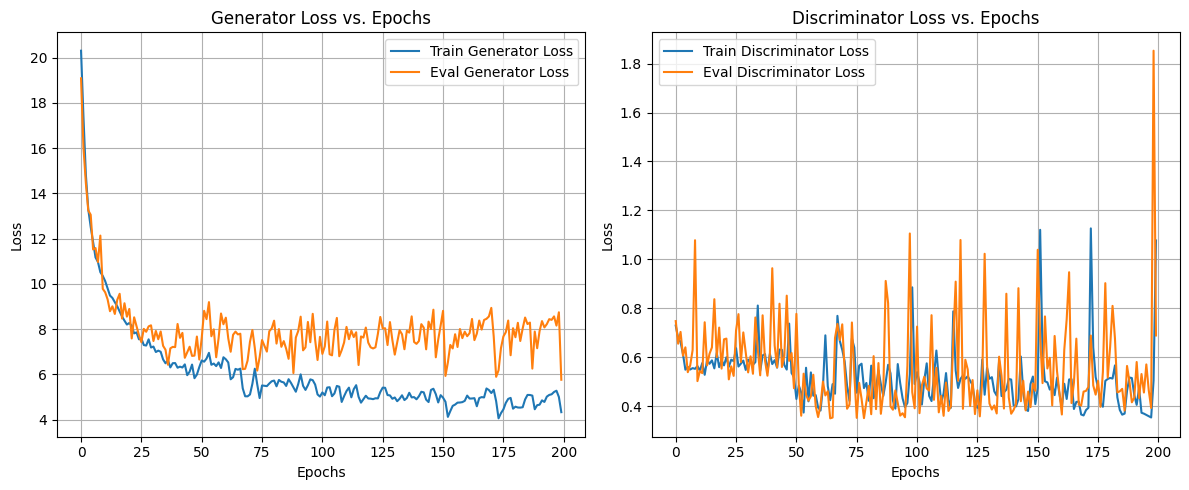

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Calculating Metrics:   0%|          | 0/3 [00:00<?, ?it/s]


--- Evaluation on Test Set ---
Average PSNR: 38.1983 dB
Average SSIM: 0.8808

--- Visualizing Sample Results ---


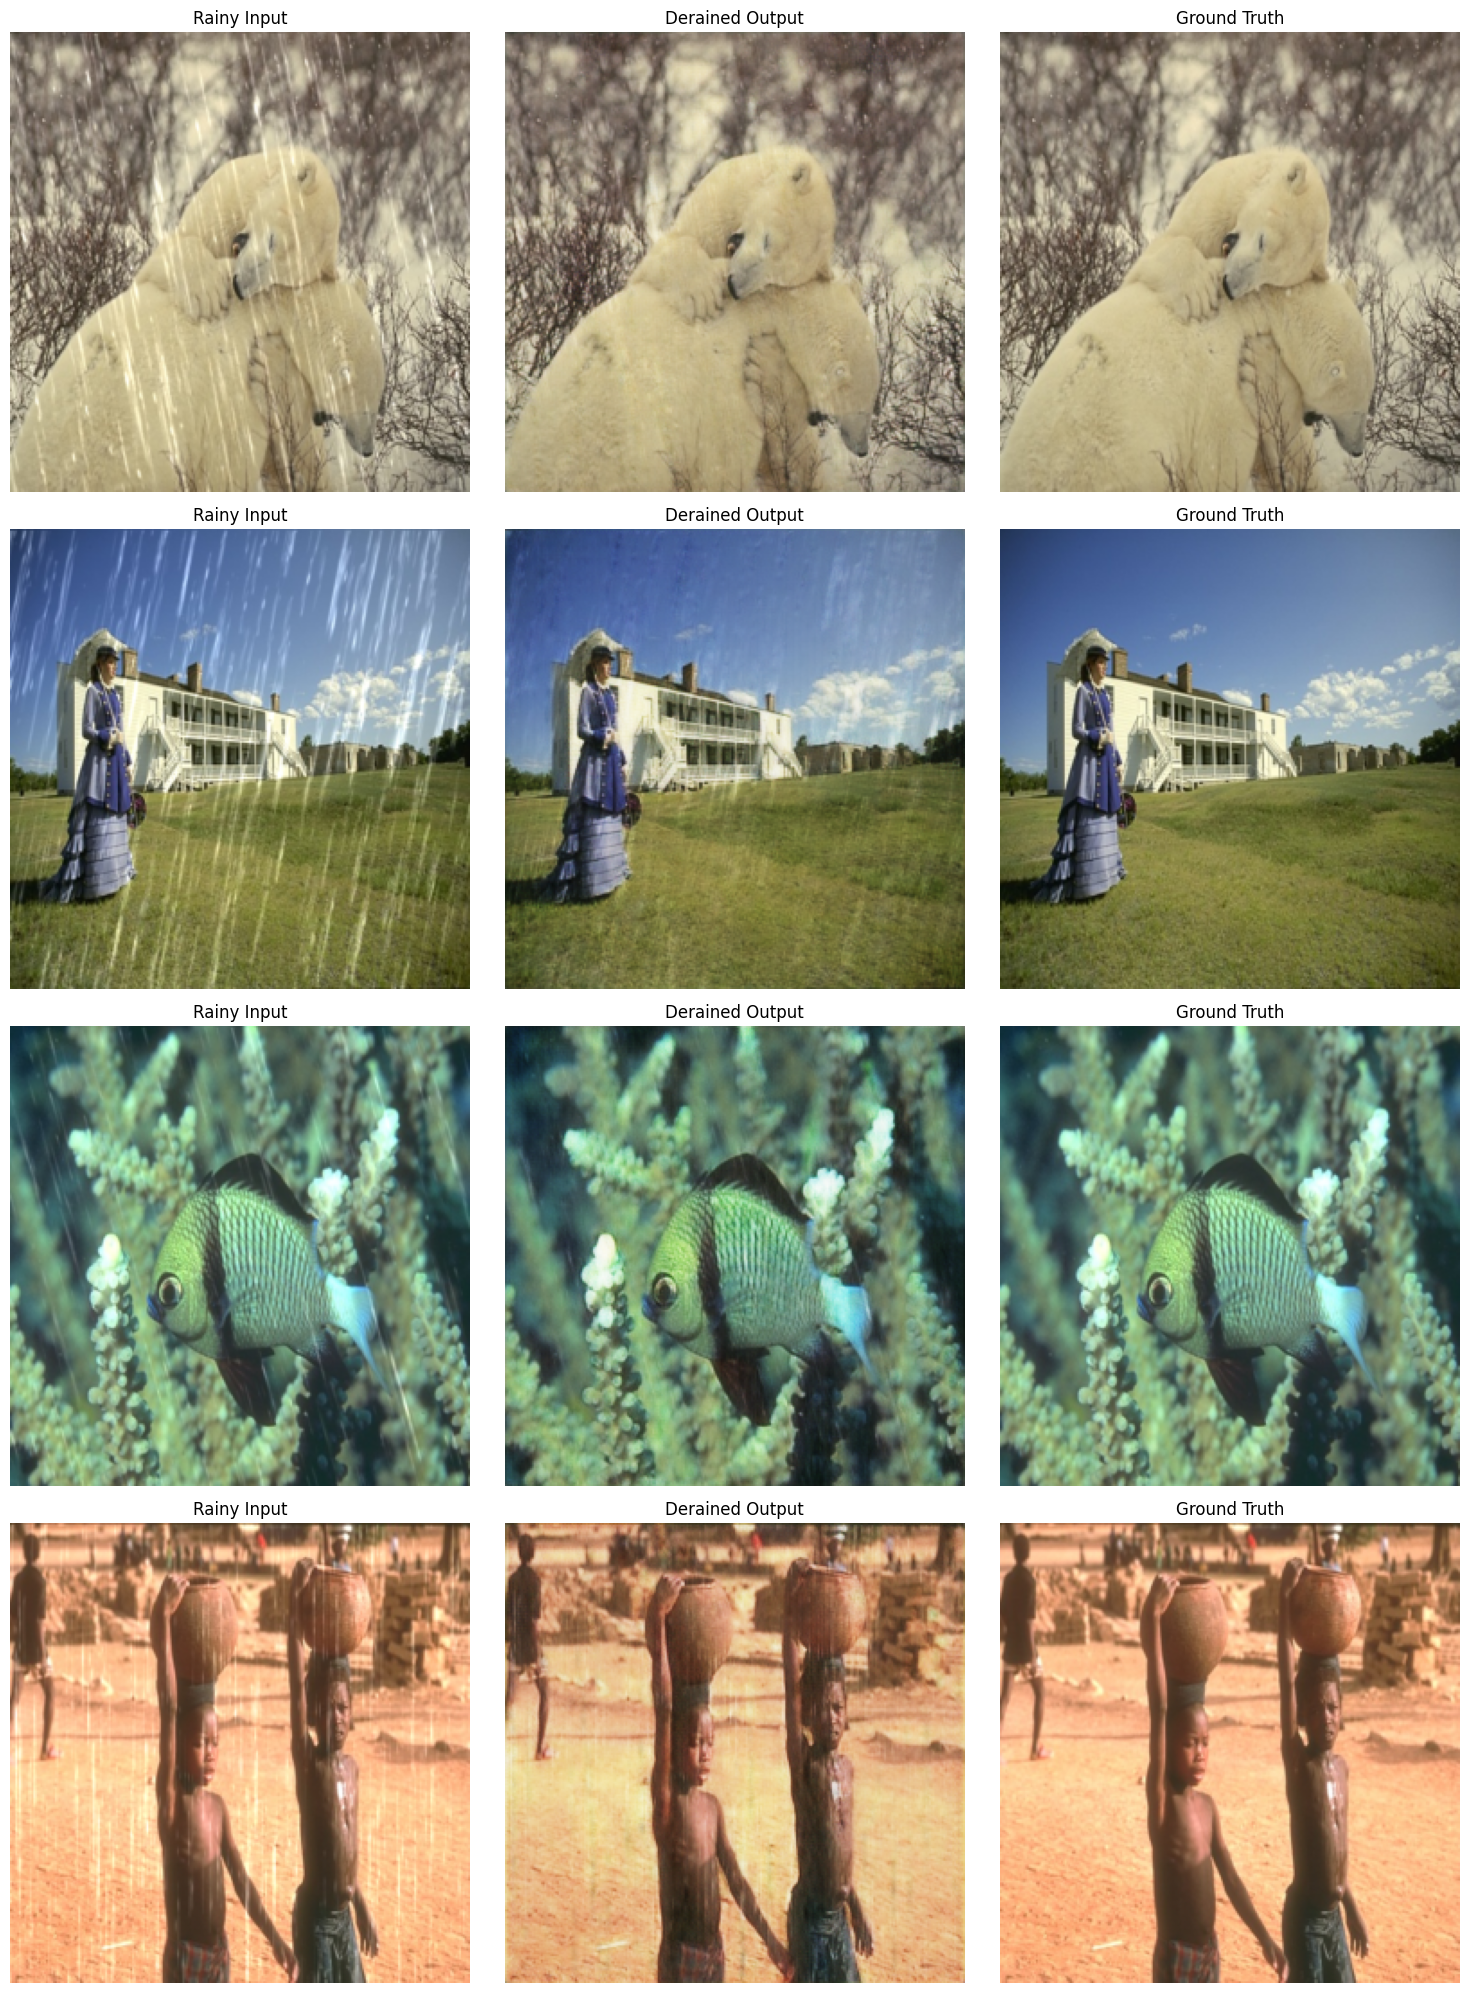

In [7]:
# --- 1. Plot Training and Evaluation Loss ---
plt.figure(figsize=(12, 5))

# Generator losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_G, label="Train Generator Loss")
plt.plot(eval_losses_G, label="Eval Generator Loss")
plt.title("Generator Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Discriminator losses
plt.subplot(1, 2, 2)
plt.plot(train_losses_D, label="Train Discriminator Loss")
plt.plot(eval_losses_D, label="Eval Discriminator Loss")
plt.title("Discriminator Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- 2. Calculate PSNR and SSIM on Test Data ---
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

total_psnr = 0.0
total_ssim = 0.0
num_samples = 0

generator.eval()
with torch.no_grad():
    for rainy_img, clean_img in tqdm(test_loader, desc="Calculating Metrics"):
        rainy_img = rainy_img.to(device)
        clean_img = clean_img.to(device)

        derained_img = generator(rainy_img)

        # Denormalize images from [-1, 1] to [0, 1] for metrics
        derained_img_norm = (derained_img * 0.5) + 0.5
        clean_img_norm = (clean_img * 0.5) + 0.5

        # Clamp values to be safe
        derained_img_norm.clamp_(0, 1)
        clean_img_norm.clamp_(0, 1)

        total_psnr += psnr(derained_img_norm, clean_img_norm) * rainy_img.size(0)
        total_ssim += ssim(derained_img_norm, clean_img_norm) * rainy_img.size(0)
        num_samples += rainy_img.size(0)

avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\n--- Evaluation on Test Set ---")
print(f"Average PSNR: {avg_psnr:.4f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


# --- 3. Visualize Results ---
def show_results(n=5):
    """Shows n random results from the test set."""
    # Get a batch of test data
    rainy_imgs, clean_imgs = next(iter(test_loader))

    rainy_imgs = rainy_imgs.to(device)
    clean_imgs = clean_imgs.to(device)

    generator.eval()
    with torch.no_grad():
        derained_imgs = generator(rainy_imgs)

    # Denormalize for visualization
    rainy_imgs = (rainy_imgs * 0.5) + 0.5
    derained_imgs = (derained_imgs * 0.5) + 0.5
    clean_imgs = (clean_imgs * 0.5) + 0.5

    plt.figure(figsize=(15, n * 5))
    for i in range(n):
        if i >= len(rainy_imgs): break

        # Display Rainy Input
        ax = plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(rainy_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Rainy Input")
        ax.axis("off")

        # Display Derained Output
        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(derained_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Derained Output")
        ax.axis("off")

        # Display Ground Truth
        ax = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(clean_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Ground Truth")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print("\n--- Visualizing Sample Results ---")
show_results(n=5)
